In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import matplotlib.patches as patches
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
from scipy.sparse import csgraph
import umap
from sklearn import linear_model
from collections import Counter
import sklearn
import scipy.stats as sps
from scipy.spatial.distance import cdist
from importlib import reload
import mygene

import gget

# locals
import utils as ut
reload(ut)

2023-03-22 15:33:45.191313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 15:33:45.324838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-03-22 15:33:45.324864: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 15:33:45.352419: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-22 15:33:46.1771

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
xy['metaTypes'] = xy['cellTypes']
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors', 'metaTypes']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

ND...
HFD8...
HFD14...
done


In [3]:
cardOutDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDOuputs/"

dfList = []

for f in os.listdir(cardOutDir):
    if 'macrophage' in f:
        fullPath = f"{cardOutDir}{f}"
        key = f.split("_")[0]
        df = pd.read_csv(fullPath)
        df = df.rename(columns={'Unnamed: 0' : 'spotId'})
        df['key'] = key
        dfList.append(df)

df = pd.concat(dfList, ignore_index=True)
print(f"{df.shape=}")
print(df['key'].value_counts())
print()


coordDir = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

dfList = []

for f in os.listdir(coordDir):
    if "coord" in f:
        fullPath = f"{coordDir}{f}"
        key = f.split("_")[0]
        cdf = pd.read_csv(fullPath)
        cdf = cdf.rename(columns={'Unnamed: 0' : 'spotId'})
        cdf['key'] = key
        dfList.append(cdf)

cdf = pd.concat(dfList, ignore_index=True)
print(f"{cdf.shape=}")
print(cdf['key'].value_counts())
print()


"""Merge CARD predictions with spatial coordinates"""
df = pd.merge(cdf, df,
              how='left', 
              left_on=['spotId', 'key'],
              right_on=['spotId', 'key'])

df = df.fillna(0)
df = df.drop_duplicates() # very important!
print(df['key'].value_counts())
df.head()

df.shape=(14836, 13)
HFD8     6782
ND       4068
HFD14    3986
Name: key, dtype: int64

cdf.shape=(14848, 4)
HFD8     6788
ND       4072
HFD14    3988
Name: key, dtype: int64

HFD8     3394
ND       2036
HFD14    1994
Name: key, dtype: int64


,spotId,x,y,key,Dendritic cells,Mac4,Stromal cells,NK cells,Mac2,Monocytes,T cells,Mac5,Mac3,Mac1,B cells
0,AAACATTTCCCGGATT.1,1139.783401,1365.804581,HFD14,3.468007e-02,0.007548,0.409201,0.170860,0.004757,0.041542,0.055275,0.219997,0.010912,0.004188,0.041040
2,AAACCGGGTAGGTACC.1,468.056902,1045.415505,HFD14,1.280364e-03,0.088368,0.187514,0.019633,0.028867,0.129969,0.040070,0.450618,0.008903,0.013757,0.031021
4,AAACCGTTCGTCCAGG.1,604.524374,1214.452428,HFD14,3.752028e-04,0.004256,0.283055,0.187004,0.021560,0.108340,0.044845,0.310869,0.003200,0.004016,0.032480
6,AAACCTAAGCAGCCGG.1,1003.708924,1433.743571,HFD14,1.198581e-07,0.009084,0.239973,0.043516,0.004948,0.057287,0.052469,0.558332,0.000064,0.023214,0.011113
8,AAACCTCATGAAGTTG.1,380.369919,960.970730,HFD14,1.377525e-02,0.029749,0.216199,0.122802,0.053188,0.158933,0.041466,0.234411,0.043126,0.037127,0.049224


In [4]:
colors = [
    '#9835e4',
    '#e48035',
    '#8e0152',
    '#9acd61',
    '#276419',
]

In [5]:
ctypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

cols = [
    'TREM2',
    # 'CD68',
    'CD9',
    'MMP12',
    # 'APOE',
    'LRP1',
    # 'ADIPOQ',
    # 'CD36',
    'MRC1',
]

res = []

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    # get macrophages
    ctype = lf[lf['cellType'].isin(ctypes)]
    cellIds = ctype['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    lf = pd.merge(ctype, rf[cols], 
                  how='left',
                  left_on='cellId',
                  right_index=True)
    
    res.append(lf)
    
    
res = pd.concat(res)
print(res.shape)
res.head()

(6431, 12)


,cellId,cellType,sampleInfo,x,y,colors,metaTypes,TREM2,CD9,MMP12,LRP1,MRC1
1,AAAGAACGTCTACAGT.1,Mac1,ND,3.089298,-1.726030,#fdbf6f,Macrophages,731.797,0,0,731.797,4390.78
2,AAAGAACTCCTCGCAT.1,Mac1,ND,3.614130,-1.571004,#fdbf6f,Macrophages,662.105,0,0,0,1765.61
3,AAAGGGCGTTAGGGTG.1,Mac3,ND,3.086352,6.166065,#fdbf6f,Macrophages,0,111.995,0,111.995,0
5,AACAAAGCACCGGCTA.1,Mac3,ND,4.344001,5.801922,#fdbf6f,Macrophages,0,171.394,0,0,85.6971
6,AACAAAGGTTCACGAT.1,Mac1,ND,0.130051,-1.583494,#fdbf6f,Macrophages,1160.67,1160.67,0,165.81,497.43


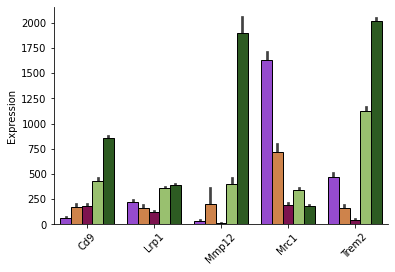

In [6]:
pdf = res.copy()

pdf = pd.melt(pdf, 
              id_vars=['cellType'], 
              value_vars=cols)

pdf['geneName'] = pdf['variable'].apply(lambda x: str(x).lower().capitalize())
pdf = pdf.sort_values(by=['cellType', 'geneName'])



plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 3, 2

sns.barplot(data=pdf, 
            y='value',
            x='geneName',
            hue='cellType',
            edgecolor='k',
            zorder=3,
            palette=colors)

plt.xlabel("")
plt.ylabel("Expression")
plt.xticks(rotation=45)
plt.gca().legend().remove()
# plt.legend(loc='upper right')
sns.despine()
# plt.grid(True, zorder=0)

In [7]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "macrophage" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        spt[key] = sdf
    
print('done')

HFD8_macrophage_spt.csv
HFD14_macrophage_spt.csv
ND_macrophage_spt.csv
done


['Mac1', 'Mac4', 'Mac5', 'Monocytes', 'Stromal cells']
ND 31.80538520439581
(2036, 17)
               spotId            x            y key  Dendritic cells  \
0  AAACAAGTATCTCCCA.1  1263.912793  1164.571691  ND         0.001127   
1  AAACAGCTTTCAGAAG.1   331.221482  1043.233630  ND         0.001650   
2  AAACAGGGTCTATATT.1   371.414081  1112.975138  ND         0.000553   
3  AAACATTTCCCGGATT.1  1213.938136  1356.563577  ND         0.002188   
4  AAACCCGAACGAAATC.1  1394.171280  1077.242752  ND         0.004858   

       Mac4  Stromal cells  NK cells      Mac2  Monocytes   T cells      Mac5  \
0  0.057020       0.815034  0.011742  0.017354   0.020917  0.007951  0.040438   
1  0.013079       0.919321  0.008373  0.006769   0.032602  0.003236  0.006750   
2  0.037635       0.850407  0.016469  0.010147   0.020347  0.016427  0.011082   
3  0.056906       0.842345  0.008430  0.010028   0.009198  0.005974  0.046854   
4  0.029673       0.821855  0.024473  0.016781   0.019047  0.017204  0.0239

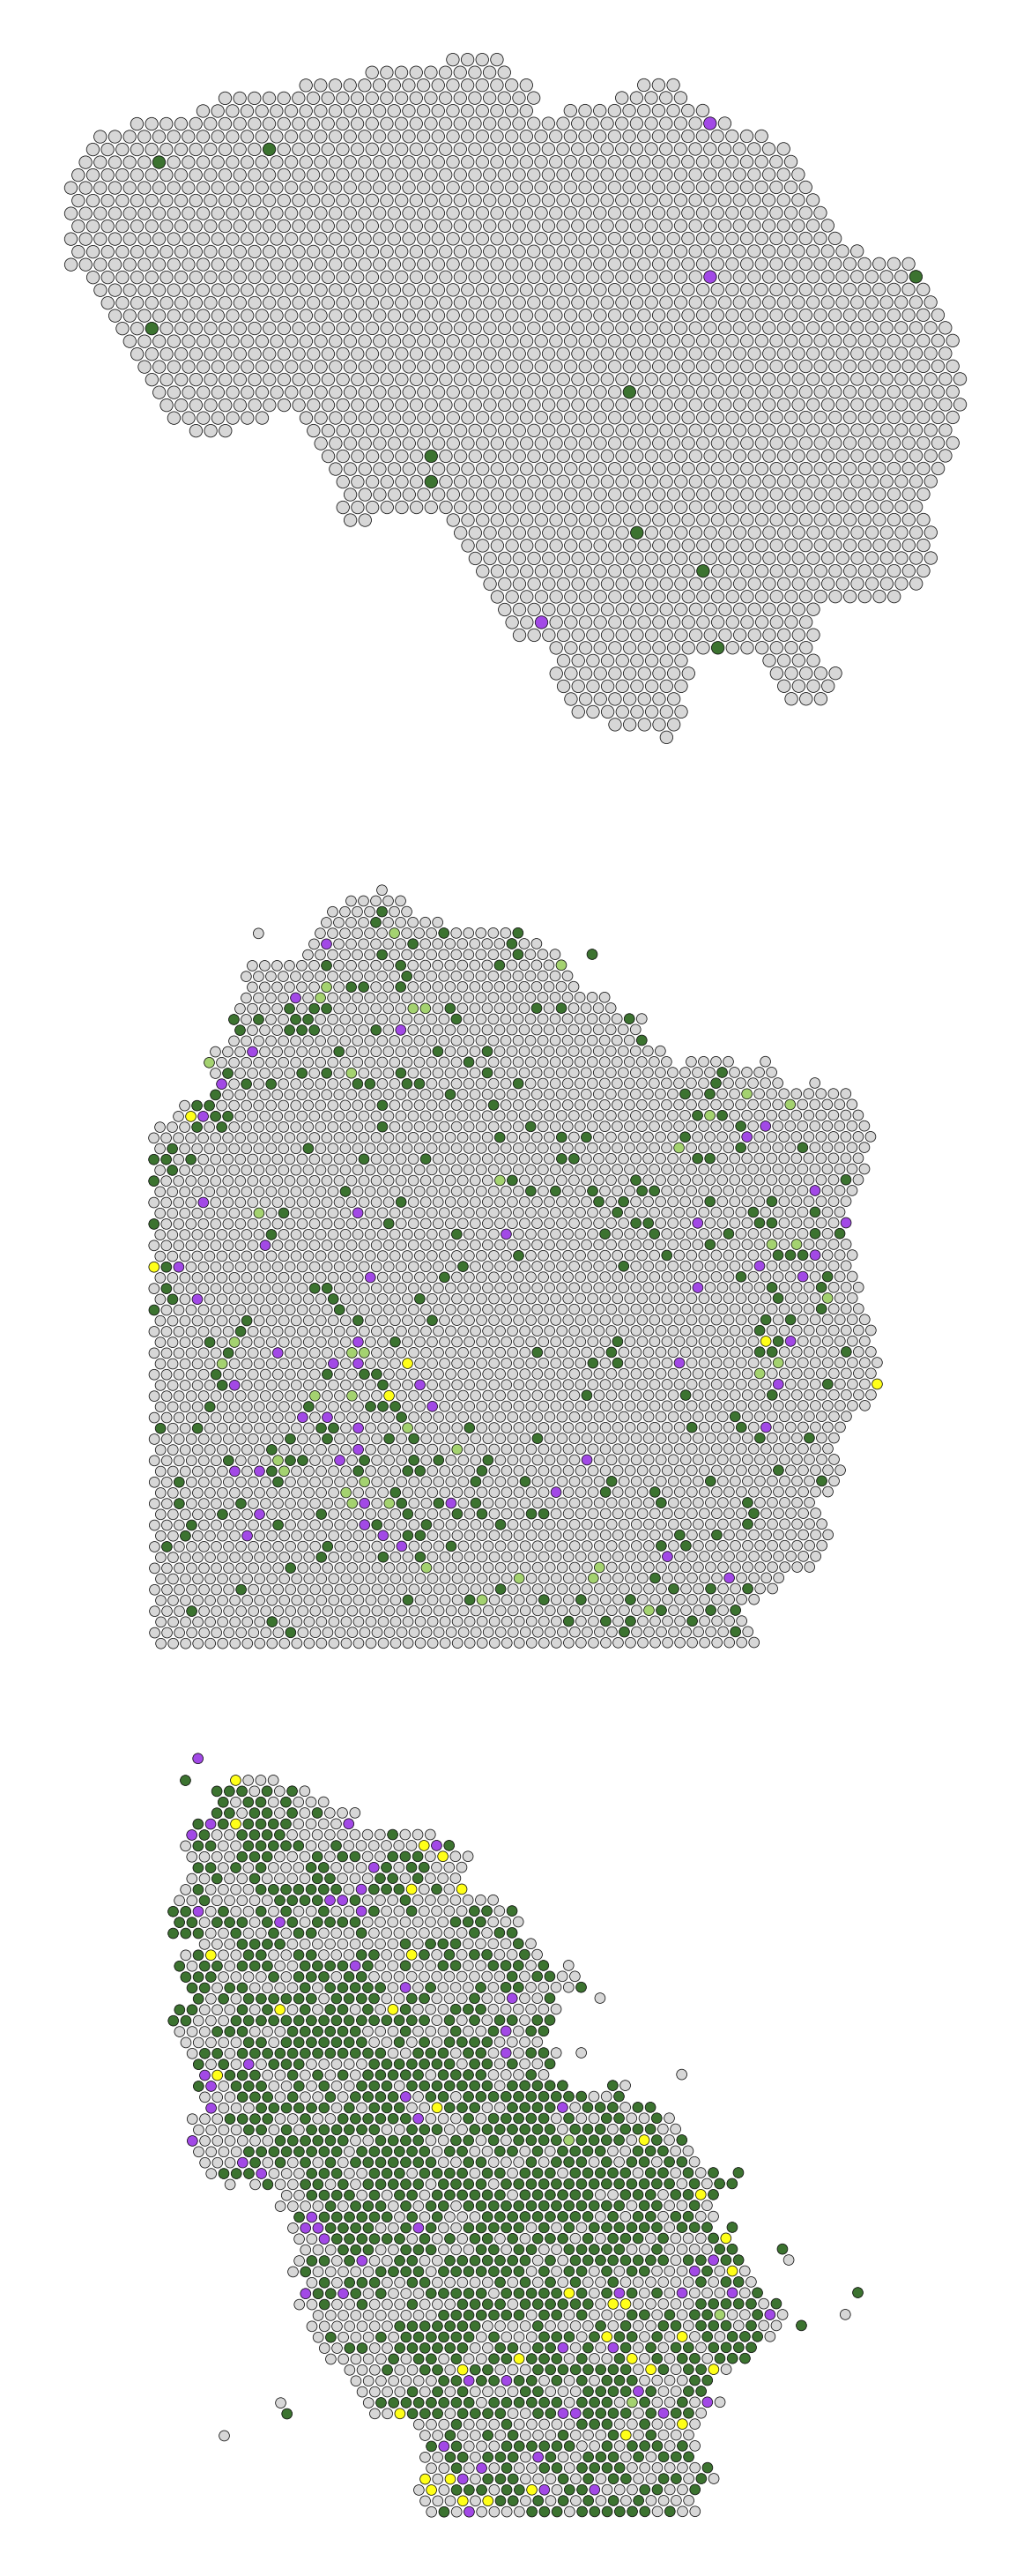

In [15]:

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = "w"
plt.rcParams['figure.figsize'] = 4, 10

ctypes = {
    'Mac1' : '#9835e4',
    'Mac4' : '#9acd61',
    'Mac5' : '#276419',
    'Monocytes' : 'yellow',
    'Stromal cells' : 'lightgrey',
}

sizes = {
    'ND' : 12,
    'HFD8' : 8,
     'HFD14' : 8,
}

lims = {
    'ND' : ([1000, 1200], [900, 1100]),
    'HFD8' : ([400, 600], [1200, 1400]),
    'HFD14' : ([800, 1000], [1100, 1300]),
}


cols = list(ctypes.keys())
print(cols)

fig, axs = plt.subplots(3, 1)
axs = axs.ravel()

for i, key in enumerate(keys):    
    
    sdf = spt[key]
    print(key, np.sqrt(sdf.size) / 250)
    
    card = df[df['key'] == key].reset_index(drop=True)
    
    card['max'] = card[cols].apply(lambda x: cols[np.argmax(x)], axis=1)

    card['color'] = card['max'].map(ctypes)
    
    print(card.shape)
    print(card.head())
    
    sns.scatterplot(data=card,
                    x='x',
                    y='y',
                    ec='k',
                    linewidth=0.2,
                    c=card['color'].to_list(),
                    alpha=0.9,
                    # s=np.sqrt(sdf.shape[1]) * 2,
                    s=sizes[key],
                    # palette=cmap,
                    legend=False,
                    ax=axs[i])
    
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel("")
    axs[i].set_ylabel("")
    axs[i].invert_yaxis()
    axs[i].set_aspect('equal')

    # axs[i].set_ylim(lims[key][1])
    # axs[i].set_xlim(lims[key][0])
    
    
    # # Create a Rectangle patch
    # rect = patches.Rectangle((50, 100), 
    #                          40, 30, 
    #                          linewidth=1, 
    #                          edgecolor='r', 
    #                          facecolor='none',
    #                          zorder=10)

    # Add the patch to the Axes
    # axs[i].add_patch(rect)
    # break
    
sns.despine(top=True, right=True, left=True, bottom=True)
    
plt.tight_layout()

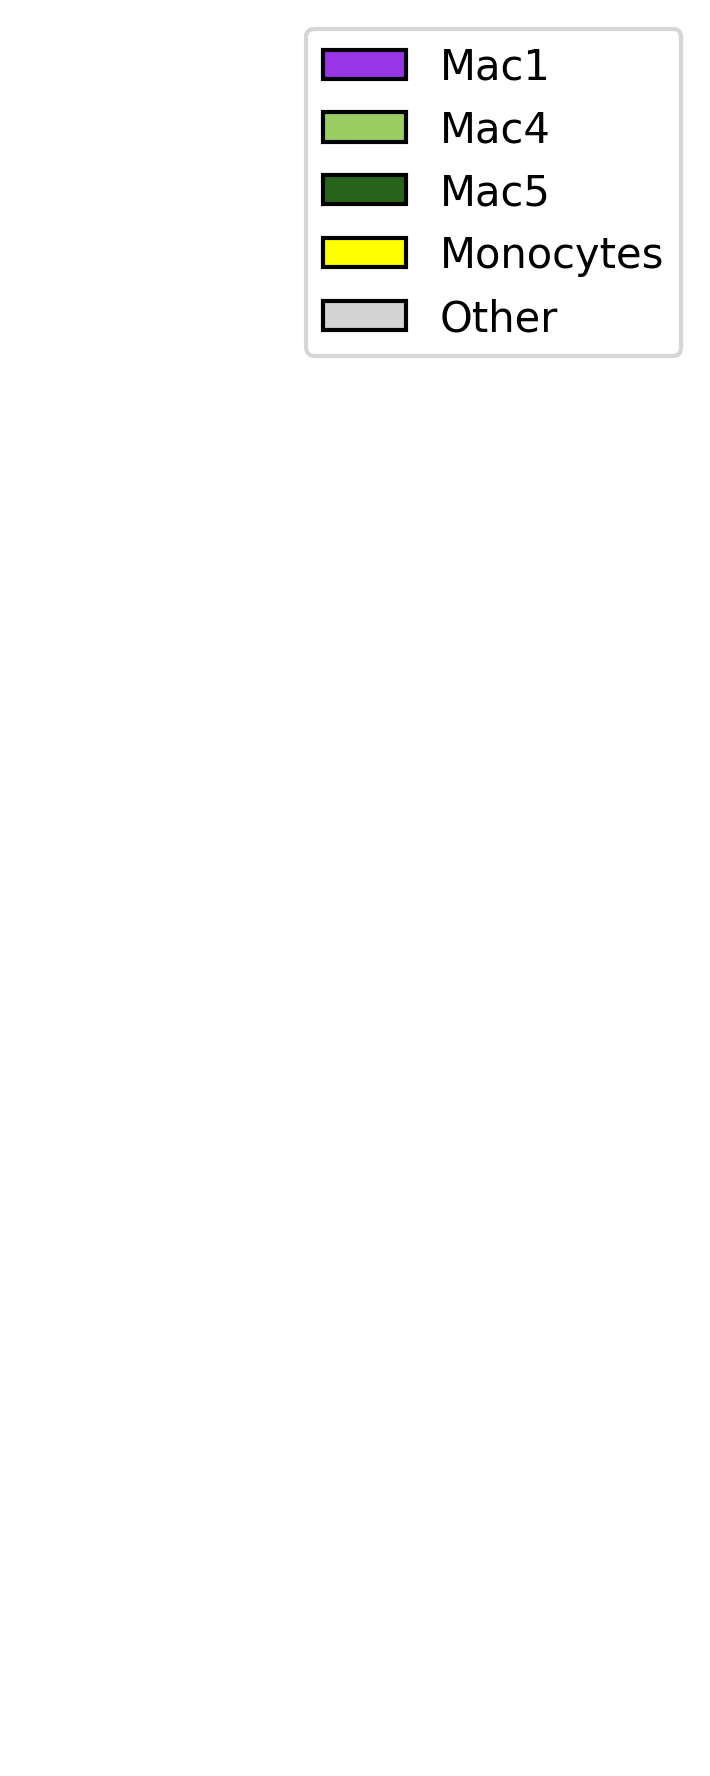

In [9]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = 'w'

ctypes = {
    'Mac1' : '#9835e4',
    'Mac4' : '#9acd61',
    'Mac5' : '#276419',
    'Monocytes' : 'yellow',
    'Other' : 'lightgrey',
}

handles = []
for k, v in ctypes.items():
    


    h = mpatches.Patch(color=v, 
                       ec='k', 
                       label=k)
    
    handles.append(h)

plt.legend(handles=handles, 
           bbox_to_anchor=(2, 1.02))
plt.axis(False)
plt.tight_layout()

In [10]:
sorted(df.columns)

['B cells',
 'Dendritic cells',
 'Mac1',
 'Mac2',
 'Mac3',
 'Mac4',
 'Mac5',
 'Monocytes',
 'NK cells',
 'Stromal cells',
 'T cells',
 'key',
 'spotId',
 'x',
 'y']

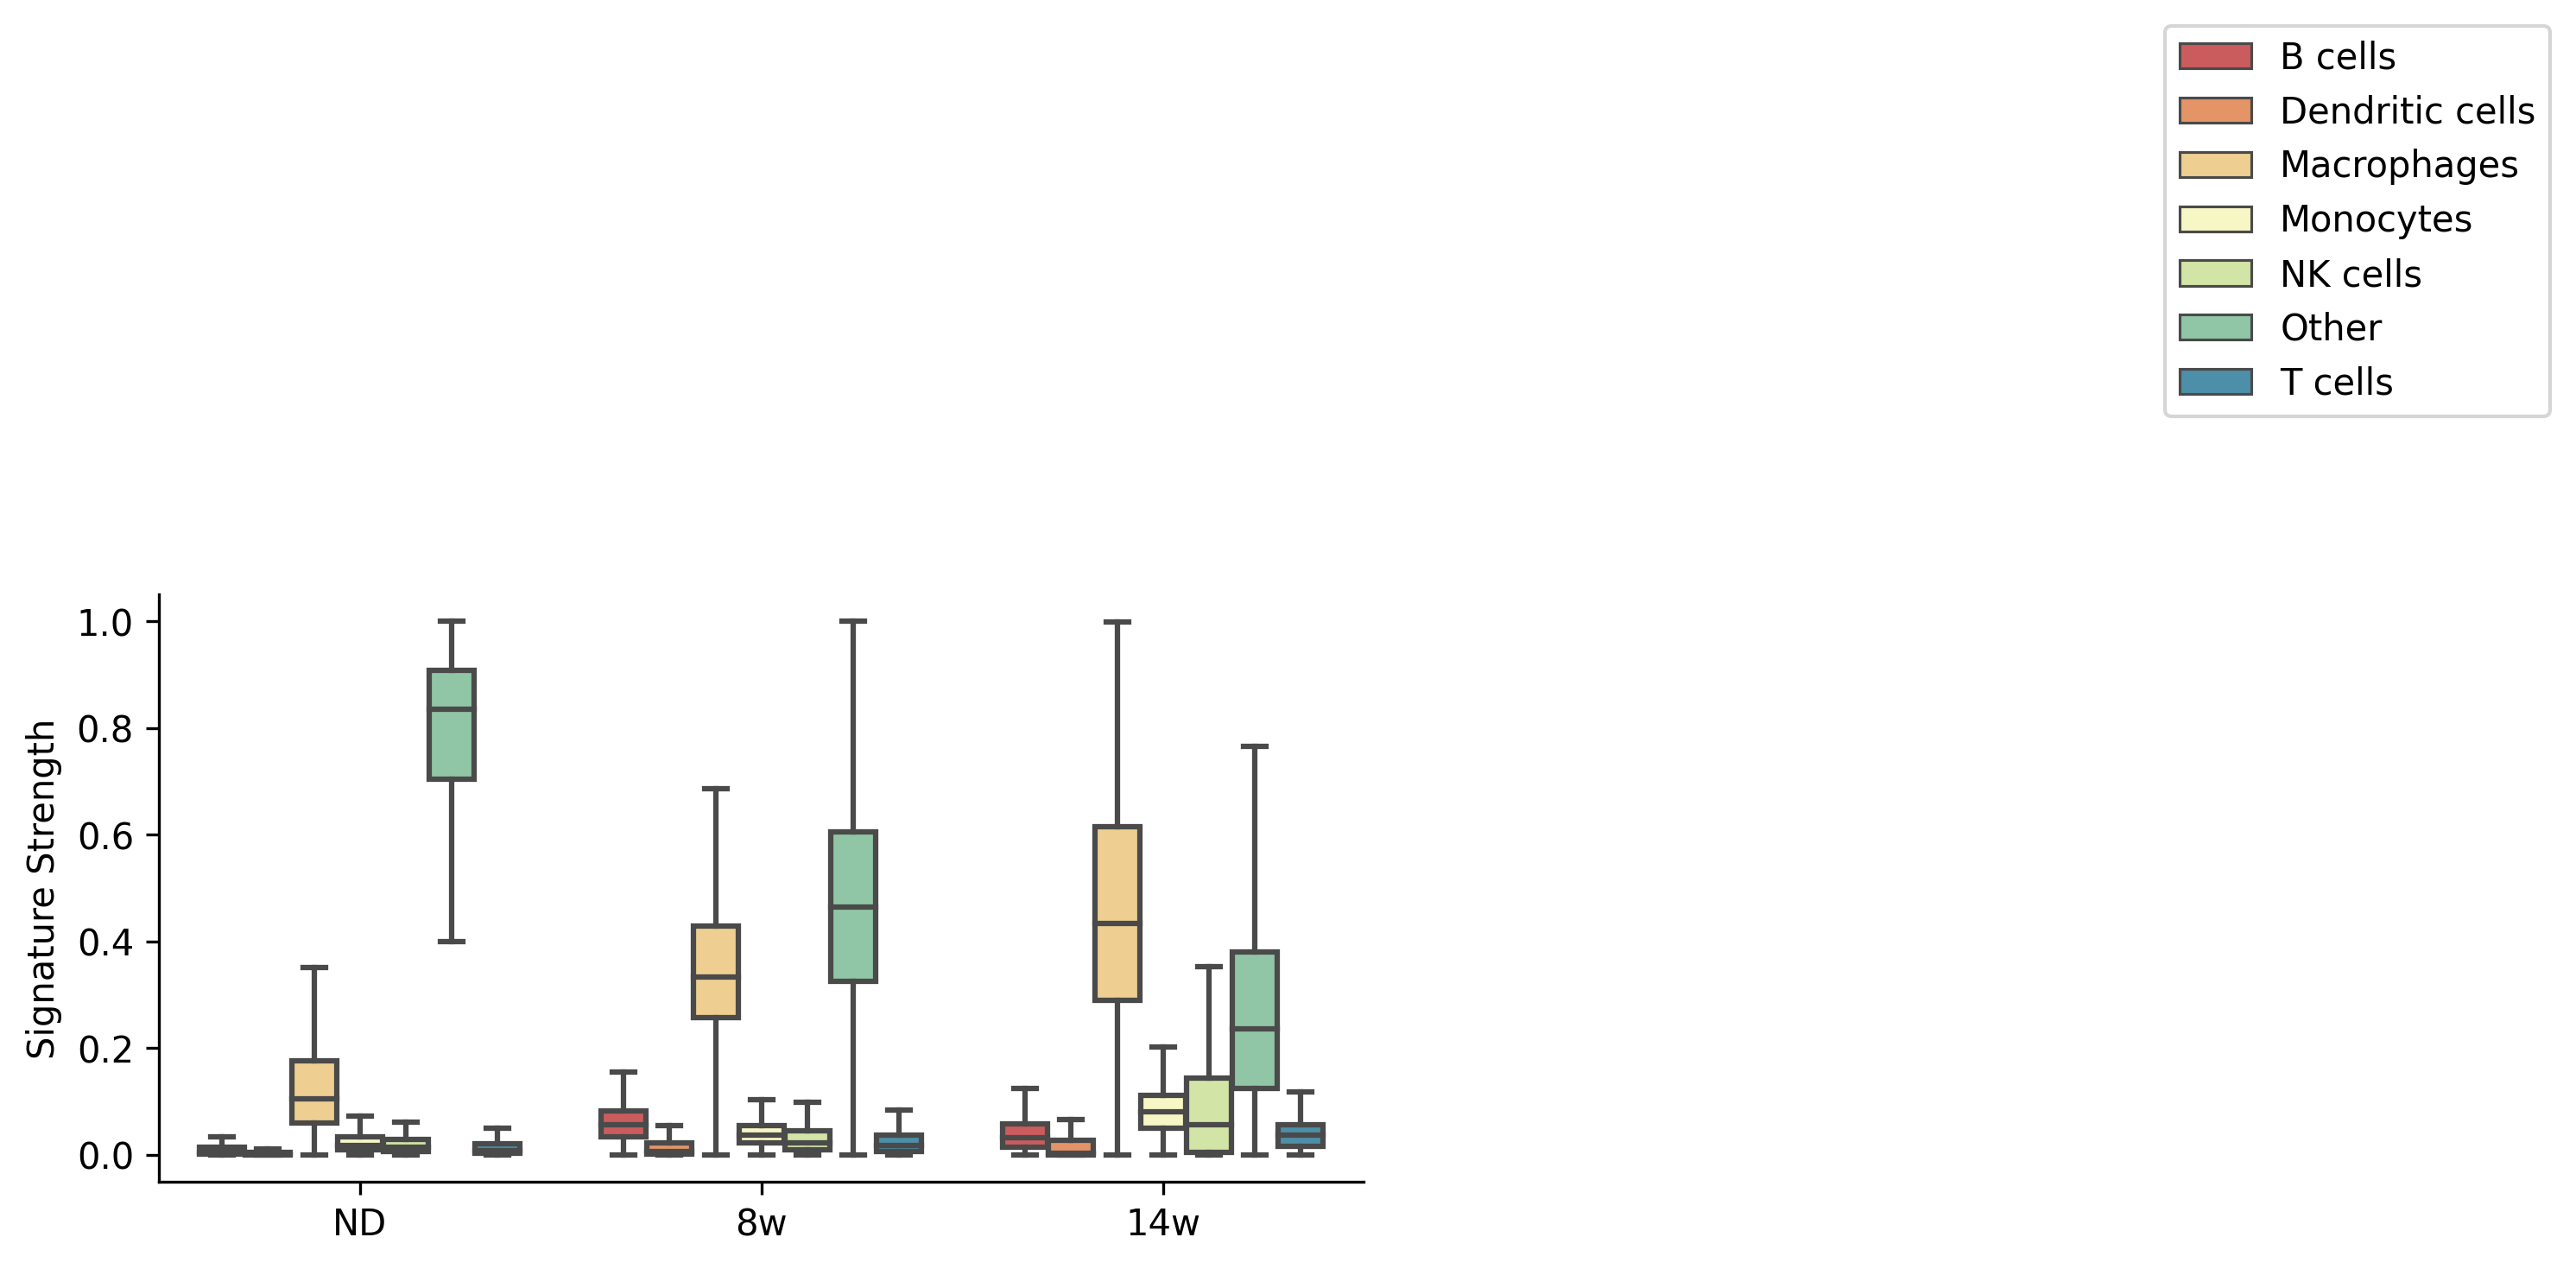

In [11]:
pdf = df.copy()
pdf['Macrophages'] = pdf[['Mac1','Mac2','Mac3','Mac4','Mac5']].sum(axis=1)

threshold = 0.01

ctypes = [
    'B cells',
    'Dendritic cells',
    # 'Mac1',
    # 'Mac2',
    # 'Mac3',
    # 'Mac4',
    # 'Mac5',
    'Macrophages',
    'Monocytes',
    'NK cells',
    'Stromal cells',
    'T cells',
]

pdf = pd.melt(pdf, 
              id_vars=['key', 'spotId'],
              value_vars=ctypes)

pdf = pdf.sort_values(by=['key', 'variable'],
                      ascending=[False, True])

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

pdf['key'] = pdf['key'].map(keyMap)

pdf['variable'] = np.where(pdf['variable'] == 'Stromal cells', 'Other', pdf['variable'])

# pdf['value'] = np.where(pdf['value'] > threshold, 1, 0)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'None'
plt.rcParams['figure.figsize'] = 6, 3

sns.boxplot(data=pdf, 
            y='value',
            x='key',
            # ec='k',
            hue='variable',
            showfliers=False,
            palette='Spectral')

plt.legend(loc='upper right', bbox_to_anchor=(2, 2))
plt.xlabel("")
plt.ylabel('Signature Strength')
sns.despine()

In [12]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
plt.rcParams['figure.facecolor'] = 'w'

ctypes = {
    'Mac1' : '#9835e4',
    'Mac4' : '#9acd61',
    'Mac5' : '#276419',
    'Monocytes' : 'yellow',
    'Stromal cells' : 'lightgrey',
}


for k, v in 


handle = mpatches.Patch(color=colordict[ctype], 
                        ec='k', 
                        label=ctype)

plt.legend(handles=handles, 
           bbox_to_anchor=(2, 1.02),
           ncols=7)
plt.axis(False)
plt.tight_layout()